In [1]:
import pathlib

from Bio.PDB import PDBParser
from Bio.Data.IUPACData import protein_letters_3to1

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib import ticker
from matplotlib.patches import Circle, Rectangle

import numpy as np
import pandas as pd

In [2]:
# Truetype fonts for better handling in Designer/Illustrator
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
# mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# define color pallete (cvd-friendly)
blue = '#005AB5'
red = '#DC3220'
gray = '#D0D0D0'

In [4]:
print(mpl.__version__)
print(pd.__version__)

3.3.4
1.2.4


In [5]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    """
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1)]
    # Return colormap object.
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [6]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [7]:
# Scientific to Common
namedict1 = {
    'anas_platyrhynchos':'Duck',
    'anser_cygnoides_domesticus':'White goose',
    'bos_taurus':'Cow',
    'callithrix_jacchus':'Marmoset',
    'canis_lupus_familiaris':'Dog',
    'chlorocebus_aethiops':'Green monkey',
    'coturnix_japonica':'Quail',
    'cricetulus_griseus':'Chinese hamster',
    'felis_catus':'Cat',
    'gallus_gallus':'Chick',
    'gorilla_gorilla':'Gorilla',
    'homo_sapiens':'Human',
    'macaca_fascicularis':'Machin',
    'macaca_mulatta':'Rhesus monkey',
    'mesocricetus_auratus':'Syrian hamster',
    'microtus_ochrogaster':'Field mouse',
    'mus_musculus':'Rat',
    'mustela_putorius':'Ferret',
    'neovison_vison':'Mink',
    'odocoileus_virginianus':'White-tailed deer',
    'panthera_leo':'Lion',
    'panthera_tigris':'Tiger',
    'papio_anubis':'Baboons',
    'peromyscus_maniculatus':'Caclus mouse', 'phodopus_roborovskii':'Desert hamster','procyon_lotor':'Raccoon','rousettus_aegyptiacus':'Egyotian fruit bat', 'sus_scrofa':'Pig'

}

# Lower case and underscore
namedict = {
    '_'.join(k.lower().split()[:2]): v
    for k, v in namedict1.items()
}

In [8]:
# Sets of sars-cov-2 positive/negative species
positive = [
    'bos_taurus',
    'callithrix_jacchus',
    'canis_lupus_familiaris',
    'chlorocebus_aethiops',
    'felis_catus',
    'gorilla_gorilla',
    'homo_sapiens',
    'macaca_fascicularis',
    'macaca_mulatta',
    'microtus_ochrogaster',
    'mustela_putorius',
    'neovison_vison',
    'odocoileus_virginianus',
    'panthera_leo',
    'panthera_tigris',
    'papio_anubis'
]

positive = list(map(namedict1.get, positive))

negative = [
    'mesocricetus_auratus'
    'anser_cygnoides_domesticus'
    'cricetulus_griseus'
    'coturnix_japonica'
    'gallus_gallus'
    'mus_musculus'
    'procyon_lotor'
    'sus_scrofa'
]

negative = list(map(namedict1.get, negative))

In [9]:
rootdir = pathlib.Path('.').resolve(strict=True)
datadir = rootdir.parent / 'refinement' / 'WT'

In [10]:
# Read in PDB files for each species
parser = PDBParser(QUIET=1)
pdbs = list(datadir.rglob('*1.pdb'))
pdbdict = {}
for pdb in pdbs:
#     print(pdb)
    chaindict = {}
    s = parser.get_structure('x', str(pdb))
    for chain in s.get_chains():
        chaindict[chain.id] = {}
        for res in chain:
            resi = res.id[1]
            resn = protein_letters_3to1.get(res.resname.capitalize())
            if resn is None:
                continue
            chaindict[chain.id][resi] = resn
    species = namedict.get(pdb.parent.name)
    if species is None:
        raise Exception(species)
    pdbdict[species]= chaindict

if not pdbdict:
    raise Exception('No models?')

In [11]:
df = pd.read_excel(datadir / 'wt.xlsx', index_col='species')
df.index = map(namedict.get, df.index)
df.head(2)

,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,...,B352,B353,B354,B355,B357,B386,B387,B388,B390,B393
Duck,-21.906202,NaN,-28.134237,NaN,-27.614197,-38.367723,-24.903184,-32.722384,-31.054315,-35.248991,...,-18.949286,-48.903939,-19.454982,-44.755891,-53.032303,-24.252217,-17.616084,-26.727020,NaN,-57.000896
White goose,-20.831042,NaN,-25.635226,NaN,-27.925055,-36.355412,-26.250433,-27.130218,-32.440343,-34.771067,...,-18.831137,-46.774536,-24.427773,-46.487609,-53.916847,-22.937969,-17.309492,-24.837131,-30.256789,-53.428595


In [12]:
# Pick columns for each protein based on chain ID
ace2_cols = [c for c in df.columns if 'B' in c]
vrbd_cols = [c for c in df.columns if 'E' in c]

ace2 = df[ace2_cols]
vrbd = df[vrbd_cols]

In [13]:
# Pick species from dataframe
# Ignore glycans here.
not_glycans = [c for c in ace2.columns if int(c[1:]) < 900]
data = ace2.loc[:, not_glycans]
data.head(2)

,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,...,B352,B353,B354,B355,B357,B386,B387,B388,B390,B393
Duck,-21.906202,NaN,-28.134237,NaN,-27.614197,-38.367723,-24.903184,-32.722384,-31.054315,-35.248991,...,-18.949286,-48.903939,-19.454982,-44.755891,-53.032303,-24.252217,-17.616084,-26.727020,NaN,-57.000896
White goose,-20.831042,NaN,-25.635226,NaN,-27.925055,-36.355412,-26.250433,-27.130218,-32.440343,-34.771067,...,-18.831137,-46.774536,-24.427773,-46.487609,-53.916847,-22.937969,-17.309492,-24.837131,-30.256789,-53.428595


In [14]:
# Sort by haddock-score
df2 = pd.read_csv(datadir.parent / 'scores.dat', index_col='species')
df2.index = map(namedict1.get, df2.index)

data['HS'] = df2['HS']
data.sort_values(by='HS', inplace=True)
data.drop(columns=['HS'], inplace=True)

# remove columns where everyone is NaN
data = data.where(data != 0).dropna(axis=1, how='all').fillna(0.0)

# Move human to top.
data['index'] = range(len(data))
data.loc['Human', 'index'] = -1
data = data.sort_values('index').drop(columns=['index'])

data.head(2)

,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,...,B352,B353,B354,B355,B357,B386,B387,B388,B390,B393
Human,-14.174228,-24.127483,-26.972598,0.0,-35.534589,-37.612629,-26.074955,-36.394649,-30.621987,-39.079761,...,-18.708893,-46.564350,-18.969618,-46.905769,-53.178113,-21.895193,-17.280243,-27.03736,-31.133835,-53.510252
Ferret,-12.173380,-22.225616,-24.603881,0.0,-38.201033,-33.000007,-28.077454,-51.170984,-29.865215,-39.951459,...,-18.059289,-43.538912,-24.923895,-45.934294,-52.411275,-22.294042,-19.330122,-27.76880,-30.992810,-53.802777


In [15]:
# Make dataframes with residue names for annotation
data_annot = data.copy(deep=True)
for row in data_annot.index:
    for col in data_annot.columns:
        chain = col[0]
        resid = int(col[1:])
        try:
            aakey = pdbdict[row][chain][resid]
        except KeyError:
            aakey = 'X'
        data_annot.loc[row, col] = aakey

data_annot.head(29)

,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,...,B352,B353,B354,B355,B357,B386,B387,B388,B390,B393
Human,S,T,I,E,E,Q,A,K,T,F,...,G,K,G,D,R,A,A,Q,F,R
Ferret,S,T,T,E,D,L,A,K,T,F,...,G,K,R,D,R,A,E,Q,F,R
Mink,S,T,T,E,D,L,A,K,T,F,...,G,K,H,D,R,A,A,Q,F,R
Dog,S,T,X,E,D,L,V,K,T,F,...,G,K,G,D,R,A,A,Q,F,R
Desert hamster,S,I,I,E,E,Q,A,K,T,F,...,G,K,E,D,R,A,T,Q,F,R
Green monkey,S,T,I,E,E,Q,A,K,T,F,...,G,K,G,D,R,A,A,Q,F,R
Gorilla,S,T,I,E,E,Q,A,K,T,F,...,G,K,G,D,R,A,A,Q,F,R
Baboons,S,T,I,E,E,Q,A,K,T,F,...,G,K,G,D,R,A,A,Q,F,R
Machin,S,T,I,E,E,Q,A,K,T,F,...,G,K,G,D,R,A,A,Q,F,R
Cow,S,T,T,E,E,Q,A,K,T,F,...,G,K,G,D,R,A,A,Q,Y,R


In [16]:
# Remove columns with 100% conservation to human.
mask = data_annot != data_annot.loc['Human']
droppable = mask.columns[mask.sum() == 0]

data_annot.drop(columns=droppable, inplace=True)
data.drop(columns=droppable, inplace=True)

In [17]:
# Compare to human
# Express difference as a fraction difference (v-vhuman / vhuman)
data = (
    data - data.loc['Human']
).fillna(0.0)

In [18]:
data['B25']

Human                 0.000000
Ferret               -2.002499
Mink                 -0.708988
Dog                  -2.553537
Desert hamster       -0.898775
Green monkey         -0.989340
Gorilla              -1.129950
Baboons               0.690469
Machin                0.014154
Cow                  -1.027521
Tiger                -1.124943
Field mouse          -0.986726
Marmoset             -0.197973
Caclus mouse         -1.603591
Syrian hamster       -0.993888
Rhesus monkey        -1.020797
White-tailed deer    -1.360438
Lion                 -0.818123
Egyotian fruit bat   -0.236939
Pig                  -2.023348
Chinese hamster      -0.283704
Quail                 6.093108
Cat                  -0.631143
White goose          -0.175478
Raccoon              -0.232082
Duck                  1.171771
Rat                  -1.510195
Chick                 5.564728
Name: B25, dtype: float64

## Figure

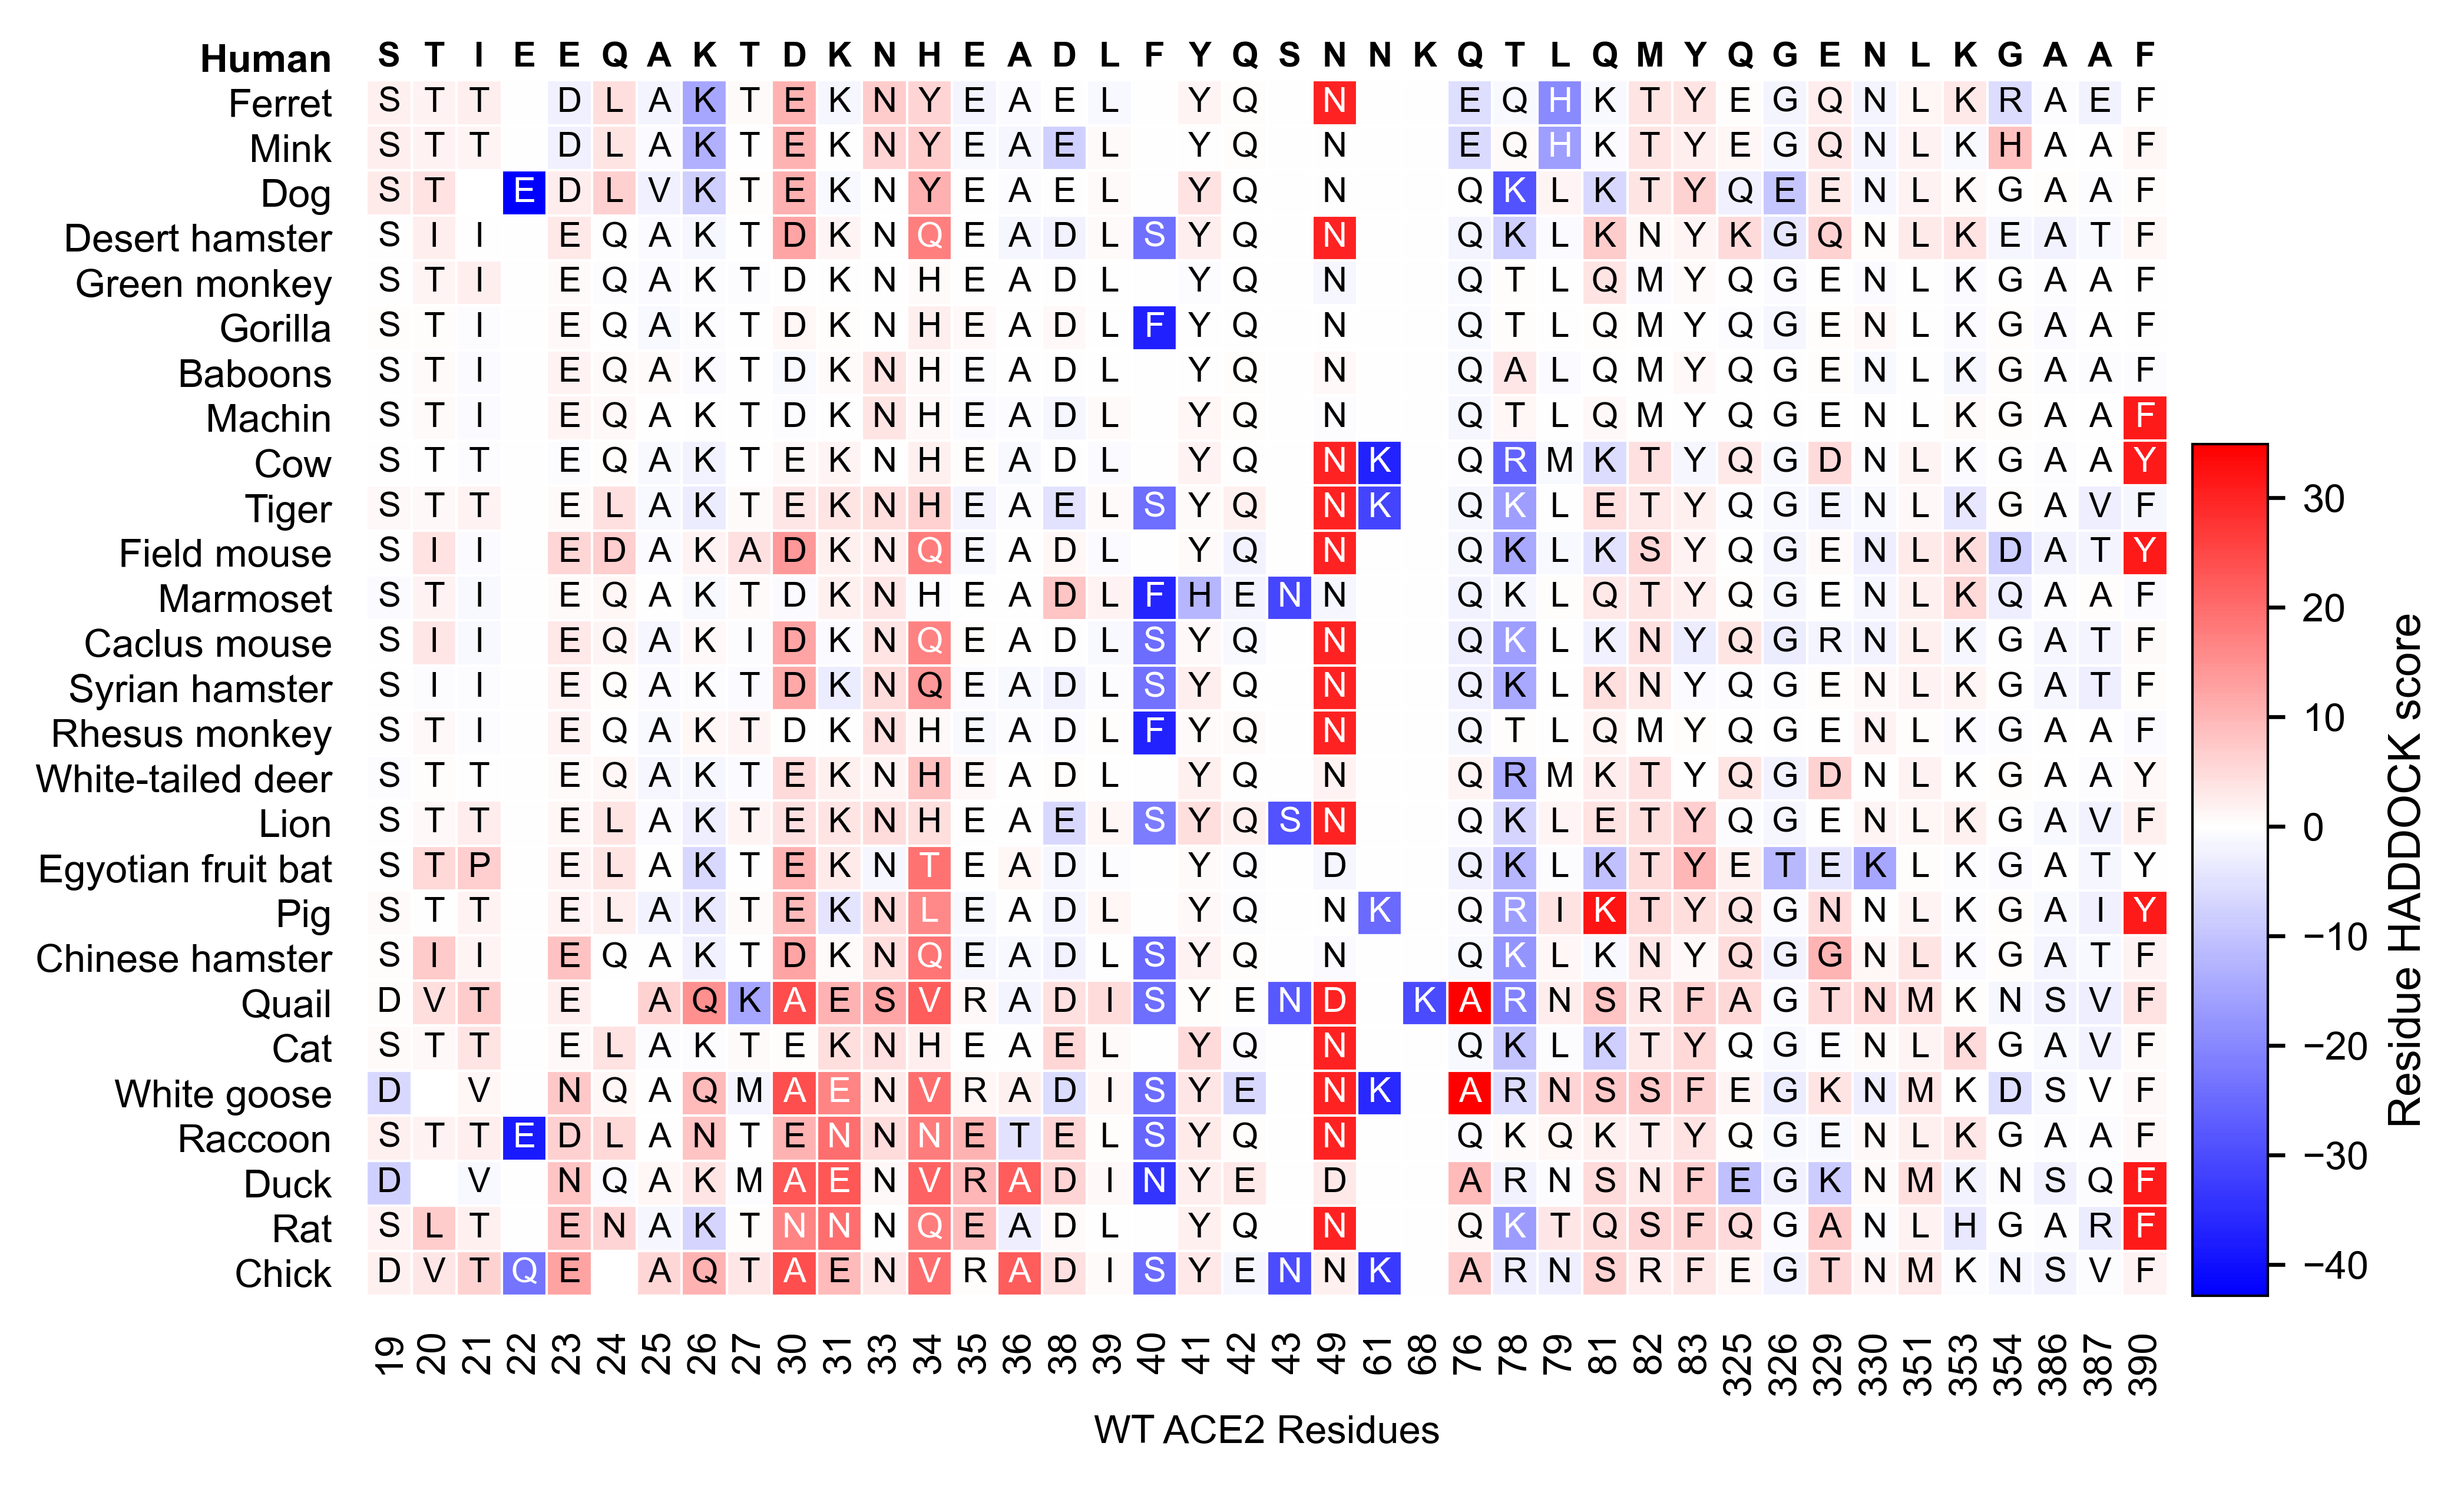

In [19]:
fig, ax1 = plt.subplots(
    nrows=1, ncols=1,
    figsize=cm2inch(18, 12),  # w,h
    dpi=600  # for viewing here on notebook
)

# mask Xs
data = data[data_annot != 'X']

# normalization
vals = data.values.ravel()
vmin, vmax = np.nanmin(vals), np.nanmax(vals)
norm = mcolors.TwoSlopeNorm(
    vmin=vmin,
    vcenter=0.,
    vmax=vmax
)

# Per species heatmap
hm = ax1.imshow(
    data.values,
    cmap='bwr',
    norm=norm,
    interpolation=None
)

# Remove spines and make white grid
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ax1.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", bottom=False, left=False)

# Set axes labels
ax1.set_xticks(np.arange(data.shape[1]))
ax1.set_yticks(np.arange(data.shape[0]))

# Replace imshow with individual squares
# for editability in illustrator/etc
nr, nc = data.shape
for x in range(nc):
    for y in range(1, nr):
        v = data.iloc[y, x]
        c = hm.cmap(hm.norm(v))

        sq = Rectangle(
            (x - .5, y - .5),
            width=1,
            height=1,
            color=c,
            linewidth=0
        )
        ax1.add_patch(sq)
    
# Add amino acid labels
# Pick font color based on luminance of background
# from seaborn source
def get_font_color(data, px, py):

    v = data.iloc[px, py]
    color = hm.cmap(hm.norm(v))
    
    rgb = mpl.colors.colorConverter.to_rgba_array(color)[:, :3]
    rgb = np.where(rgb <= .03928, rgb / 12.92, ((rgb + .055) / 1.055) ** 2.4)
    lum = rgb.dot([.2126, .7152, .0722])
    return "k" if lum > .408 else "w"

    
nx, ny = data.shape
for i in range(nx):
    if not i:
        fontweight = 'bold'
    else:
        fontweight = 'regular'

    for j in range(ny):
        if i and data.iloc[i, j] in (0.0, np.nan):
            continue
        text = ax1.text(
            j, i, data_annot.iloc[i, j],
            ha="center", va="center",
            color=get_font_color(data, i, j),
            fontweight=fontweight,
            fontfamily='Arial',
            size=7
        )
    
# Handle labels
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')

xlabels = []
for c in data.columns:
    resi = c[1:]  # clip chain name
    if int(resi) > 1000:  # replace first digit with X
        resi = 'x' + resi[1:]
    xlabels.append(resi)

ax1.set_xticklabels(
    xlabels,
    fontsize=8,
    rotation=90
)

ax1.set_yticklabels(
    data.index,
    fontsize=8
)

ax1.set_xlabel('WT ACE2 Residues', size=8)

for l in ax1.yaxis.get_ticklabels():  # bold average
    l.set_fontweight('bold')
    break

# Create colorbar
fig.canvas.draw()  # draw first to get positions
ax_pos = ax1.get_position()
cbax = fig.add_axes([
    ax_pos.xmax + 0.01,  # xmax + pad
    ax_pos.ymin,
    0.03,
    0.51
])

cbar = fig.colorbar(
    hm,
    cax=cbax,
    orientation='vertical',
    pad=0
)
cbar.ax.set_ylabel('Residue HADDOCK score', size=9)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_fontsize(8)

cbar.outline.set_linewidth(0.5)

# Hide imshow data
data_copy = data.copy(deep=True)
for col in data_copy.columns:
    data_copy[col].values[:] = np.nan
hm.set_data(data_copy)

In [43]:
fig.savefig('WT-ace2-residues.tiff', transparent=True);